# Momentum and Reversion - The Poor Man's Trading Strategies

<a href="https://www.kaggle.com/code/addarm/momentum-and-mean-reversion-quant" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

![MidJourney FinFluencer Impression 2023.11.1](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/FinFluencerBanner.png)

<!-- @import "[TOC]" {cmd="toc" depthFrom=1 depthTo=6 orderedList=false} -->

In the world of quantitative trading, various strategies are employed to gain a competitive edge in financial markets. 
Most popular trading strategies involve momentum and trend - popular means they will not generate much alpha, unless you're planning to sell these as youtube Financial courses.

Momentum and trend approach capitalizes on the **idea** that assets that have exhibited recent price strength will continue to do so in the near future, or the opposite in when there is weakness. There is a slight detail between trend and momentum worth noting:
- Trend-following is directional absolute returns that looks at beta across the market.
- Momentum is relative returns and market-neutral as it looks at a class or sector cross-section.

Reversion is the **assumption** that prices reverts back to a mean or means, over a period of time.

In this article, we will explore these strategies, and provide Python code implementations for you to try out. 

We will keep to the latest post-pandemic market regime, therefore most stock prices will start in the 2021s. All strategies are long-only, and unleveraged.

## Prepare Your Python

Have a jupyter environment ready, and `pip install` these libraries:
- numpy
- pandas
- yfinance


In [13]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os

import dotenv
%load_ext dotenv

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import calculate_profit, load_ticker_ts_df, plot_strategy

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Running Local...


# Momentum & Trend Strategies

Let's describe it with an example, say if an asset's price has risen for the past week, it's likely to continue upward. This approach capitalizes on the belief that the future mirrors the past, either in an upward or downward trend. As the WSB crowd used to say, stonks only go up.

While the strategy is easy to grasp and implement, it does have drawbacks:
- Ignores market noise and special events, potentially smoothing out important fluctuations.
- Transaction fees can accumulate due to frequent orders.
- Everyone does it, there is little to no edge.

Let's implement a few of these strategies.

## Simple Moving Average (SMA) Crossover

The Moving Average Crossover strategy involves calculating two or more moving averages for an asset's price: a short-term moving average (called a fast SMA) and a long-term moving average (slow SMA).

The code below implements this strategy:


In [14]:
def double_simple_moving_average_signals(ticker_ts_df, short_window=5, long_window=30):
    """
    Generate trading signals based on a double simple moving average (SMA) strategy.
    Parameters:
    - aapl_ts_df (pandas.DataFrame): A DataFrame containing historical stock data.
    - short_window (int): The window size for the short-term SMA.
    - long_window (int): The window size for the long-term SMA.
    Returns:
    - signals (pandas.DataFrame): A DataFrame containing the trading signals.
    """
    signals = pd.DataFrame(index=ticker_ts_df.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = ticker_ts_df['Close'].rolling(window=short_window,
                                                          min_periods=1,
                                                          center=False).mean()
    signals['long_mavg'] = ticker_ts_df['Close'].rolling(window=long_window,
                                                         min_periods=1,
                                                         center=False).mean()
    # Generate signal when SMAs cross
    signals['signal'] = np.where(
        signals['short_mavg'] > signals['long_mavg'], 1, 0)
    signals['orders'] = signals['signal'].diff()
    signals.loc[signals['orders'] == 0, 'orders'] = None
    return signals

This function takes a timeseries of any stock, and sets a short (fast SMA) and long (slow SMA) rolling windonw, and compares the 2 across the timeline. 
When the fast SMA is higher, a buy **signal** is generated (1), and when it's lower, a sell **signal** is produced (-1).

Let's run everything together:

c:\Users\worker\workspace\quant_research\analysis_utils.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)


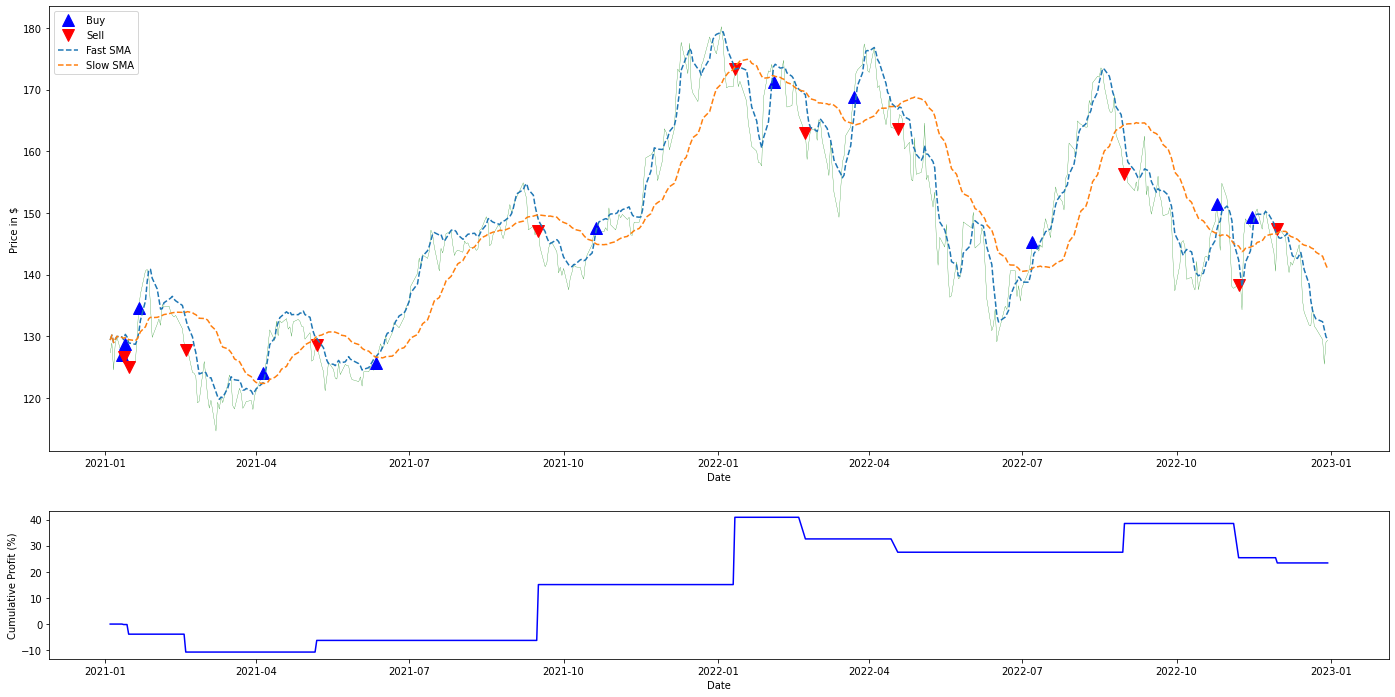

In [15]:
aapl_ts_df = load_ticker_ts_df('AAPL',
                               start_date='2021-01-01',
                               end_date='2023-01-01')
signal_df = double_simple_moving_average_signals(aapl_ts_df, 5, 30)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, ax2 = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

# Add short and long moving averages
ax1.plot(signal_df.index, signal_df['short_mavg'],
         linestyle='--', label='Fast SMA')
ax1.plot(signal_df.index, signal_df['long_mavg'],
         linestyle='--', label='Slow SMA')
ax1.legend(loc='upper left', fontsize=10)
plt.show()

Throught 2 years, this strategy gave us 30% return, and comparing it agianst the S&P 500 of 10% - that's not bad at all.

## Naive Momentum

This strategy is based on the number of times a price increases or decreases. It assumes that when a price increases for a certain number of consecutive days, it's a signal to buy, and when it decreases, it's a signal to sell. We willl reuse some of the utility functions from the SMA strategy above.

Here's the code to implement a naive version of it:

c:\Users\worker\workspace\quant_research\analysis_utils.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)


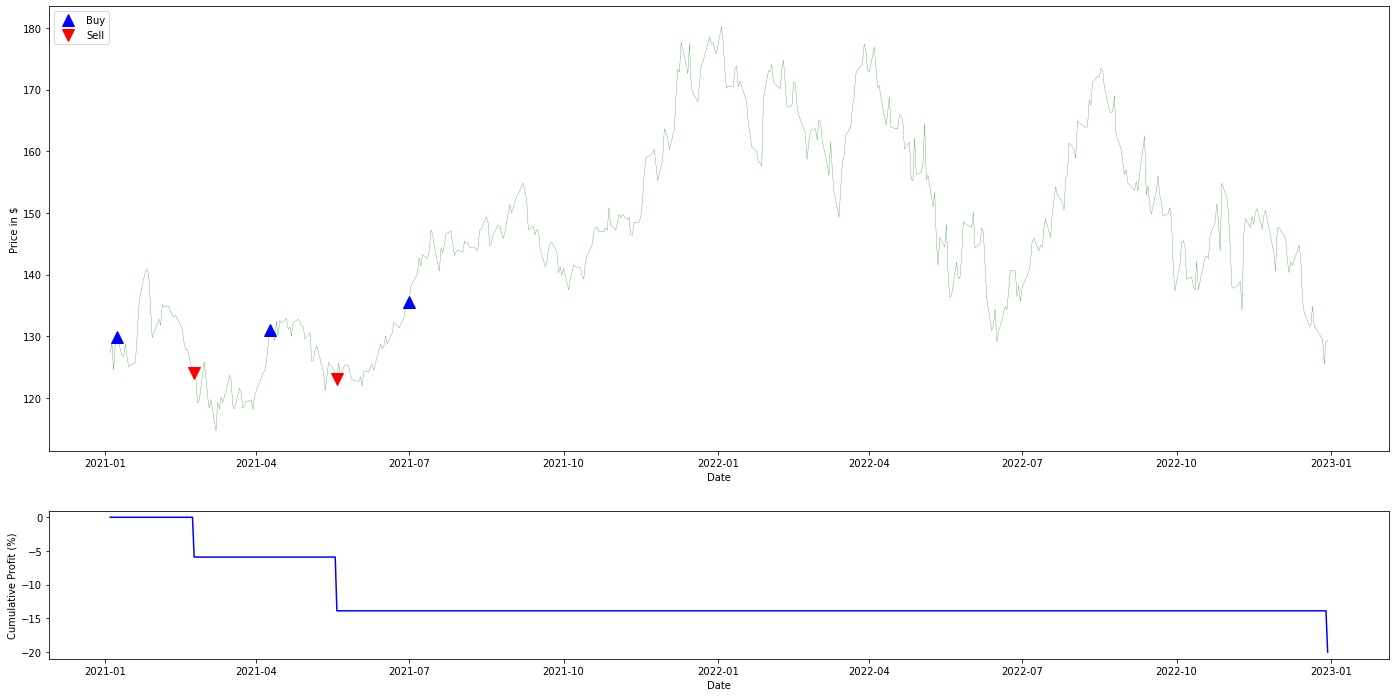

In [16]:
def naive_momentum_signals(ticker_ts_df, nb_conseq_days=2):
    """
    Generate naive momentum trading signals based on consecutive positive or negative price changes.
    Parameters:
    - ticker_ts_df (pandas.DataFrame): A DataFrame containing historical stock data.
    - nb_conseq_days (int): The number of consecutive positive or negative days to trigger a signal.
    Returns:
    - signals (pandas.DataFrame): A DataFrame with 'orders' column containing buy (1) and sell (-1) signals.
    """
    signals = pd.DataFrame(index=ticker_ts_df.index)
    signals['orders'] = 0

    price = ticker_ts_df['Adj Close']
    price_diff = price.diff()

    signal = 0
    cons_day = 0

    for i in range(1, len(ticker_ts_df)):
        if price_diff[i] > 0:
            cons_day = cons_day + 1 if price_diff[i] > 0 else 0
            if cons_day == nb_conseq_days and signal != 1:
                signals['orders'].iloc[i] = 1
                signal = 1
        elif price_diff[i] < 0:
            cons_day = cons_day - 1 if price_diff[i] < 0 else 0
            if cons_day == -nb_conseq_days and signal != -1:
                signals['orders'].iloc[i] = -1
                signal = -1

    return signals


signal_df = naive_momentum_signals(aapl_ts_df)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, _ = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

ax1.legend(loc='upper left', fontsize=10)
plt.show()

This strategy is a losing one, as it didn't give us any returns. We would have fared better inversing this model (just like you ought to do with most of WSB's stock analysis). Hint to achieve this: `signals['orders'] = signals['orders'] * -1`

Granted, this strategy is usually based on the market in general rather than a single instrument, and is in a shorter timeframe.

# Reversion Strategies

As an example: Elon tweets that he will install blockchain in teslas, and the market gets overzelous in its buying of Tesla.  The next day, everyone realizes that fundamentally nothing changes, so the market loses interest and the price reverts back to an acceptable level.

Therefore, any instrument that divereges too fast from a benchmark in either direction, will have to revert back in the longer timeframe.

Just like trends and momentum - this is a simple strategy, that smooths everything and is gernerally used by all market participants. 

## Mean Reversion

Here we assume that the price of a stock will stay in the vicinity of its mean.

Below is the signal code:

In [17]:
def mean_reversion_signals(ticker_ts_df, entry_threshold=1.0, exit_threshold=0.5):
    """
    Generate mean reversion trading signals based on moving averages and thresholds.
    Parameters:
    - ticker_ts_df (pandas.DataFrame): A DataFrame containing historical stock data.
    - entry_threshold (float): The entry threshold as a multiple of the standard deviation.
    - exit_threshold (float): The exit threshold as a multiple of the standard deviation.

    Returns:
    - signals (pandas.DataFrame): A DataFrame with 'orders' column containing buy (1) and sell (-1) signals.

    """
    signals = pd.DataFrame(index=ticker_ts_df.index)
    signals['mean'] = ticker_ts_df['Adj Close'].rolling(
        window=20).mean()  # Adjust the window size as needed
    signals['std'] = ticker_ts_df['Adj Close'].rolling(
        window=20).std()  # Adjust the window size as needed

    signals['signal'] = np.where(ticker_ts_df['Adj Close'] > (
        signals['mean'] + entry_threshold * signals['std']), 1, 0)
    signals['signal'] = np.where(ticker_ts_df['Adj Close'] < (
        signals['mean'] - exit_threshold * signals['std']), -1, 0)

    signals['orders'] = signals['signal'].diff()
    signals.loc[signals['orders'] == 0, 'orders'] = None

    return signals

In this function, we find the standard deviation and the mean.

if the price diverges from its mean by a standard deviaion and a factor, it will generate a signal.

Let's test it together with the functions we created:

c:\Users\worker\workspace\quant_research\analysis_utils.py:46: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  profit = pd.Series(index=prices.index)


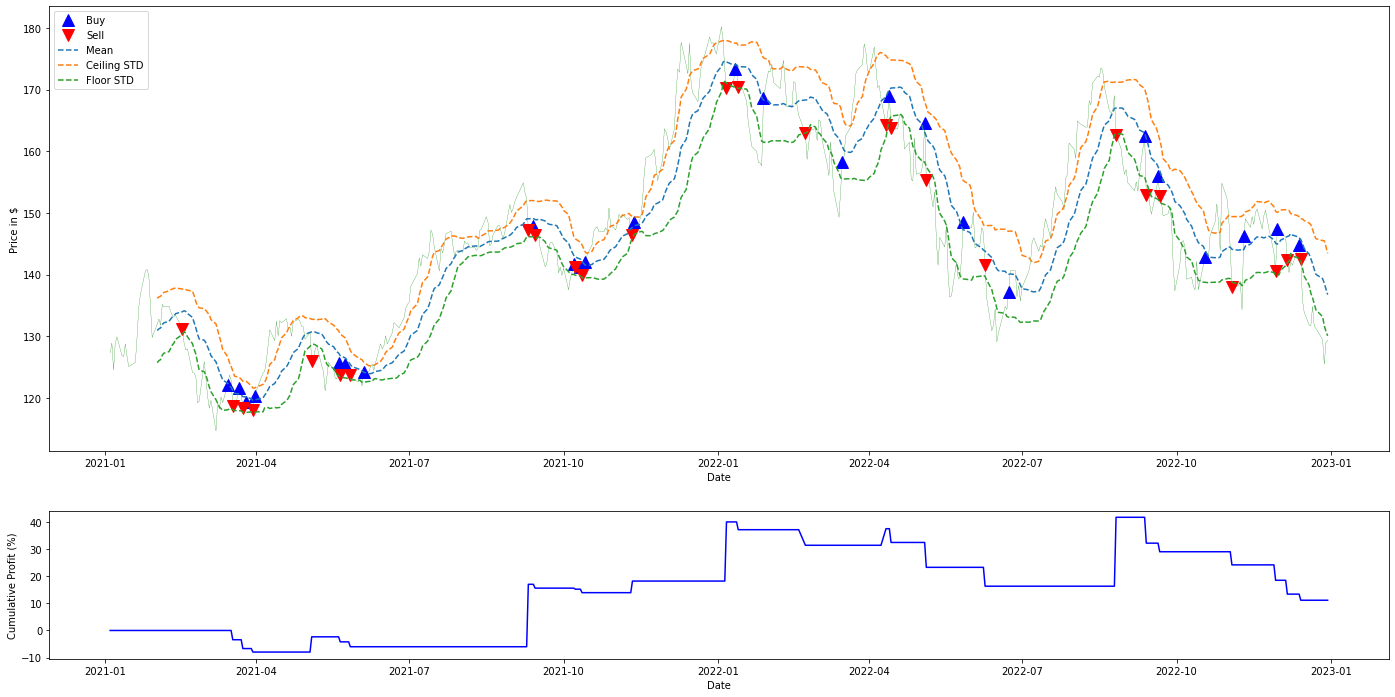

In [18]:
signal_df = mean_reversion_signals(aapl_ts_df)
profit_series = calculate_profit(signal_df, aapl_ts_df["Adj Close"])
ax1, _ = plot_strategy(aapl_ts_df["Adj Close"], signal_df, profit_series)

ax1.plot(signal_df.index, signal_df['mean'], linestyle='--', label="Mean")
ax1.plot(signal_df.index, signal_df['mean'] +
         signal_df['std'], linestyle='--', label="Ceiling STD")
ax1.plot(signal_df.index, signal_df['mean'] -
         signal_df['std'], linestyle='--', label="Floor STD")
ax1.legend(loc='upper left', fontsize=10)
plt.show()

10% not bad returns, though you would have done just as well placing your money in the S&P500. 

In future articles, we will look at more advanced versions of reversion strategies, mainly: Pair-Trading and Statistical-Arbitrage.
We will also look at strategies' metrics, like the sharpe-ratio, which is what makes this strategy weak even though it returned the same as the S&P500.

# Conclusion

We've explored the simple stratgies of momentum and mean reversion trading strategies.
Momentum strategies harness the power of trends to predict future price movements. On the other hand, mean reversion strategies are grounded in the idea that price or returns tend to revert to the mean after experiencing extreme movements.

Remember that no single strategy guarantees success, unless you are shilling it on youtube, as a finfluencer!

![MidJourney FinFluencer Impression 2023.11.1](https://raw.githubusercontent.com/adamd1985/quant_research/main/images/FinFluencer_youtube.png)

## References

- https://numpy.org/doc/stable/reference/
- https://www.investopedia.com/terms/t/trendtrading.asp
- https://www.investopedia.com/terms/m/meanreversion.asp

## Github

Article here is also available on [Github](https://github.com/adamd1985/quant_research/blob/main/momentum-and-mean-reversion-quant.ipynb)

Kaggle notebook available [here](https://www.kaggle.com/code/addarm/momentum-and-mean-reversion-quant)


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.